# Final Project

#### ``Objectives``


1. Implement a **CNN model** to classify real and fake AI-generated human face images.
2. Improve generalization performance and reduce overfitting using **image transformation** and **data augmentation** techniques.

#### ``Motivation``

These days, AI generated human face images are being misused online, especially on social media to spread misinformation. Many of those fake face images are hard to distinguish from real ones with human eyes. Classifying real and fake human face images would be helpful for end users to avoid scams.

#### ``Data``

The project uses the "Fake-Vs-Real-Faces (Hard)" dataset to train a CNN model to predict whether a human face iamge is a real one or fake one generated by AI.

The original dataset is hosted by Kaggle: [https://www.kaggle.com/datasets/hamzaboulahia/hardfakevsrealfaces](https://www.kaggle.com/datasets/hamzaboulahia/hardfakevsrealfaces)

---
### Step 1: Import libraries

In [122]:
# standard
import os
import numpy as np
import pandas as pd

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import utils as sk_utils
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score, roc_auc_score

# plots
import seaborn as sns
import matplotlib.pyplot as plt

---
### Step 2: Data ingestion

### Split the images into train, validation, and test set in a 0.6, 0.2, 0.2 ratio

In [123]:
# Define paths containing the images
data_dir = "data"
fake_dir = os.path.join(data_dir, "fake")
real_dir = os.path.join(data_dir, "real")

def get_dataset(fake_dir, real_dir, balance=False):
    fake_images = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir)]
    real_images = [os.path.join(real_dir, f) for f in os.listdir(real_dir)]

    if balance:
        """Truncates each class to the minimum count"""
        min_images = min(len(fake_images), len(real_images))
        fake_images = fake_images[:min_images]
        real_images = real_images[:min_images]

    image_paths = fake_images + real_images
    labels = ["fake"] * len(fake_images) + ["real"] * len(real_images)
    return image_paths, labels

def split_indices(indices, split_ratio):
    train = int(split_ratio[0] * len(indices))
    val = int(split_ratio[1] * len(indices))

    train_idx = indices[:train]
    val_idx = indices[train : train + val]
    test_idx = indices[train + val :]
    return train_idx, val_idx, test_idx

def split_data(image_paths, labels, split_ratio, seed=42, balance=False):
    image_paths, labels = np.array(image_paths), np.array(labels)

    np.random.seed(seed)

    if not balance:
        idx = np.arange(len(image_paths))
        np.random.shuffle(idx)
        train_idx, val_idx, test_idx = split_indices(idx, split_ratio)

    else:
        """Balance class by class"""
        fake_idx = np.where(labels == "fake")[0]
        real_idx = np.where(labels == "real")[0]

        np.random.shuffle(fake_idx)
        np.random.shuffle(real_idx)

        fake_train, fake_val, fake_test = split_indices(fake_idx, split_ratio)
        real_train, real_val, real_test = split_indices(real_idx, split_ratio)

        train_idx = np.concatenate([fake_train, real_train])
        val_idx = np.concatenate([fake_val, real_val])
        test_idx = np.concatenate([fake_test, real_test])

        np.random.shuffle(train_idx)
        np.random.shuffle(val_idx)
        np.random.shuffle(test_idx)

    return (
        (image_paths[train_idx], labels[train_idx]),
        (image_paths[val_idx], labels[val_idx]),
        (image_paths[test_idx], labels[test_idx]),
    )

def print_dataset(name, labels_array):
    print(f"{name} Dataset: {len(labels_array)}")
    print(f"fake: {np.sum(labels_array == 'fake')}")
    print(f"real: {np.sum(labels_array == 'real')}")

image_paths, labels = get_dataset(fake_dir, real_dir, balance=True)
(train_x, train_y), (val_x, val_y), (test_x, test_y) = split_data(
    image_paths, labels, split_ratio=[0.6, 0.2, 0.2], balance=True
)

print_dataset("Train", train_y)
print_dataset("Validation", val_y)
print_dataset("Test", test_y)
print_dataset("Full", np.concatenate([train_y, val_y, test_y]))

Train Dataset: 706
fake: 353
real: 353
Validation Dataset: 234
fake: 117
real: 117
Test Dataset: 238
fake: 119
real: 119
Full Dataset: 1178
fake: 589
real: 589


---
### Step 3: Exploratory Data Analysis (EDA)

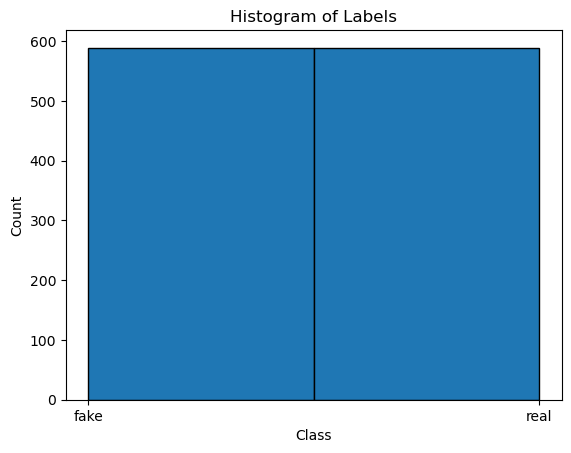

In [124]:
plt.figure()
plt.hist(labels, bins=len(set(labels)), edgecolor='black')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Histogram of Labels')
plt.show()

### Load the images into real and fake classes

In [125]:
# load images
images = []

for path in image_paths:
    img = load_img(path)
    images.append(img)

real_ind = [i for i, x in enumerate(labels) if x == "real"]
fake_ind = [i for i, x in enumerate(labels) if x == "fake"]

real_images = [images[i] for i in real_ind]
fake_images = [images[i] for i in fake_ind]

### Print sample real and fake images

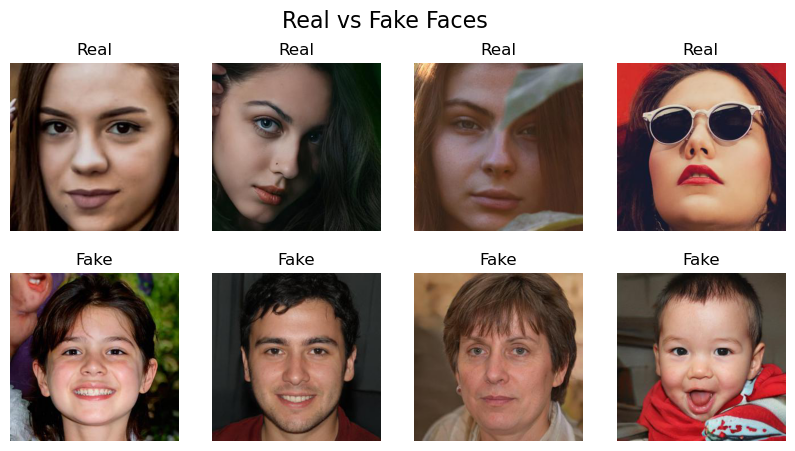

In [126]:
# Show real and fake faces
plt.figure(figsize=(10, 5))

# Show 4 real faces
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(real_images[i])
    plt.axis('off')
    plt.title("Real")

# Show 4 fake faces
for i in range(4):
    plt.subplot(2, 4, 4 + i + 1)
    plt.imshow(fake_images[i])
    plt.axis('off')
    plt.title("Fake")

plt.suptitle("Real vs Fake Faces", fontsize=16)
plt.show()

### Distribution of the image data

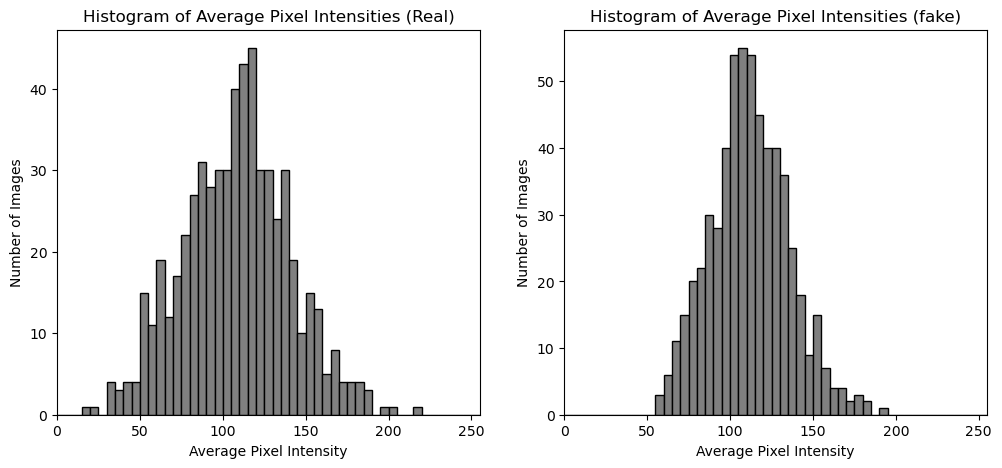

In [127]:
# Avg pixel intesity
avg_pixels_real = [np.mean(img) for img in np.array(real_images)]
avg_pixels_fake = [np.mean(img) for img in np.array(fake_images)]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Real
axs[0].hist(avg_pixels_real, range(0, 256+5, 5), color='gray', edgecolor='black')
axs[0].set_xlabel('Average Pixel Intensity')
axs[0].set_ylabel('Number of Images')
axs[0].set_title('Histogram of Average Pixel Intensities (Real)')
axs[0].set_xlim(0, 255)

# Fake
axs[1].hist(avg_pixels_fake, range(0, 256+5, 5), color='gray', edgecolor='black')
axs[1].set_xlabel('Average Pixel Intensity')
axs[1].set_ylabel('Number of Images')
axs[1].set_title('Histogram of Average Pixel Intensities (fake)')
axs[1].set_xlim(0, 255)

plt.show()

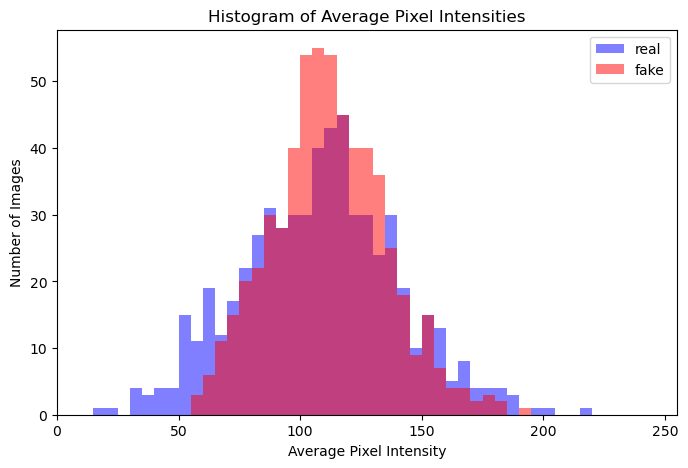

In [128]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(avg_pixels_real, bins=range(0, 256+5, 5), label='real', color='blue', alpha=0.5)
ax.hist(avg_pixels_fake, bins=range(0, 256+5, 5), label='fake', color='red', alpha=0.5)
ax.set_title("Histogram of Average Pixel Intensities")
ax.set_xlabel("Average Pixel Intensity")
ax.set_ylabel("Number of Images")
ax.set_xlim(0,255)
ax.legend()

plt.show()

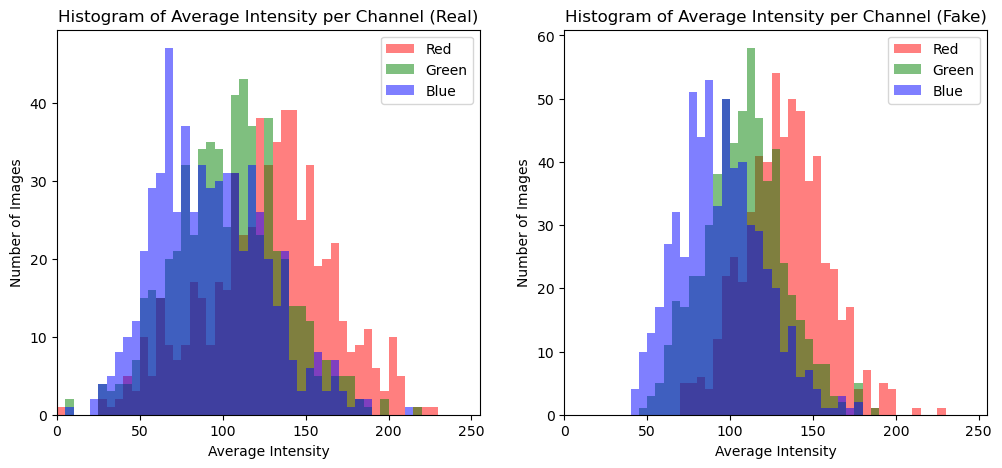

In [129]:
# Average Per channel (RGB)

avg_per_channel_real = [np.array(img).mean(axis=(0, 1)) for img in np.array(real_images)]
avg_per_channel_fake = [np.array(img).mean(axis=(0, 1)) for img in np.array(fake_images)]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist([arr[0] for arr in avg_per_channel_real], bins=range(0, 256+5, 5), color='red', alpha=0.5, label='Red')
axs[0].hist([arr[1] for arr in avg_per_channel_real], bins=range(0, 256+5, 5), color='green', alpha=0.5, label='Green')
axs[0].hist([arr[2] for arr in avg_per_channel_real], bins=range(0, 256+5, 5), color='blue', alpha=0.5, label='Blue')
axs[0].set_title("Histogram of Average Intensity per Channel (Real)")
axs[0].set_xlabel("Average Intensity")
axs[0].set_ylabel("Number of Images")
axs[0].set_xlim(0,255)
axs[0].legend()

axs[1].hist([arr[0] for arr in avg_per_channel_fake], bins=range(0, 256+5, 5), color='red', alpha=0.5, label='Red')
axs[1].hist([arr[1] for arr in avg_per_channel_fake], bins=range(0, 256+5, 5), color='green', alpha=0.5, label='Green')
axs[1].hist([arr[2] for arr in avg_per_channel_fake], bins=range(0, 256+5, 5), color='blue', alpha=0.5, label='Blue')
axs[1].set_title("Histogram of Average Intensity per Channel (Fake)")
axs[1].set_xlabel("Average Intensity")
axs[1].set_ylabel("Number of Images")
axs[1].set_xlim(0,255)
axs[1].legend()
plt.show()

---
### Step 4: Data preprocessing

### Perform image transformation and augmentation:
1. Normalize pixel values from [0, 255] to [0, 1]
2. Randomly rotate images by up to 20 degrees
3. Shift images horizontally by up to 20% of width
4. Shift images vertically by up to 20% of height
5. Apply shear transformation (slanting the image)
6. Randomly zoom in/out by up to 20%
7. Randomly flip images horizontally

In [130]:
train_df = pd.DataFrame({"image_path": train_x, "label": train_y})
val_df = pd.DataFrame({"image_path": val_x, "label": val_y})
test_df = pd.DataFrame({"image_path": test_x, "label": test_y})

# Image properties
img_height, img_width = 300, 300
batch_size = 32

# Data augmentation and loading
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_set = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
)

val_set = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="image_path",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
)

test_set = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="label",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False,
)

Found 706 validated image filenames belonging to 2 classes.
Found 234 validated image filenames belonging to 2 classes.
Found 238 validated image filenames belonging to 2 classes.


---
### Step 5: Modeling

### Define a custom early stopping class

In [131]:
# Early stopping callback: stops training when both train and validation accuracy are high enough
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        stop_acc = 0.9
        train_acc = logs.get("accuracy")
        val_acc = logs.get("val_accuracy")
        if train_acc >= stop_acc and val_acc >= stop_acc:
            print(
                f"\nStopping early at epoch {epoch + 1} - train accuracy: {train_acc:.4f}, validation accuracy: {val_acc:.4f}"
            )
            self.model.stop_training = True

### Build a FFNN (feedforward neural network) Model as baseline model
- A Flatten layer to convert a 2D image input into a 1D vector
- Two Dense layers with 128 neurons, using "ReLU" activation function
- One output layer for binary classification, using "sigmoid" activation function

In [132]:
# Define baseline FFNN Model
def build_baseline(learning_rate):
    model = Sequential()
    
    model.add(Input(shape=(300, 300, 3)))
    model.add(Flatten(input_shape=(img_height, img_width, 3)))
    model.add(Dense(units=128, activation="relu"))
    model.add(Dense(units=128, activation="relu"))
    model.add(Dense(units=1, activation="sigmoid"))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy",
            tf.keras.metrics.AUC(name='auc')],
    )

    return model

baseline_model = build_baseline(learning_rate = 0.0001)
baseline_model.summary()

/home/ho/.pyenv/versions/anaconda3-2024.02-1/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_18 (Flatten)            │ (None, 270000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 128)            │    34,560,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,576,769 (131.90 MB)

 Trainable params: 34,576,769 (131.90 MB)

 Non-trainable params: 0 (0.00 B)

In [133]:
max_epochs = 50

# Train the FFNN model
history_baseline = baseline_model.fit(
    train_set,
    validation_data=val_set,
    epochs=max_epochs,
    callbacks=[CustomEarlyStopping()],
    verbose=1
)

/home/ho/.pyenv/versions/anaconda3-2024.02-1/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - accuracy: 0.5113 - auc: 0.5050 - loss: 2.7794 - val_accuracy: 0.5812 - val_auc: 0.8806 - val_loss: 0.6873
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - accuracy: 0.6035 - auc: 0.6370 - loss: 0.7342 - val_accuracy: 0.7778 - val_auc: 0.8708 - val_loss: 0.4761
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - accuracy: 0.6701 - auc: 0.7451 - loss: 0.6118 - val_accuracy: 0.7222 - val_auc: 0.8368 - val_loss: 0.5852
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.5938 - auc: 0.6040 - loss: 1.3142 - val_accuracy: 0.6923 - val_auc: 0.8019 - val_loss: 0.5570
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 244ms/step - accuracy: 0.6567 - auc: 0.7007 - loss: 0.6607 - val_accuracy: 0.6795 - val_auc: 0.8338 - val_loss: 0.5762
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 245ms/step - accuracy: 0.6739 - auc: 0.7231 - loss: 0.7026 - val_accuracy: 0.7735 - val_auc: 0.8741 - val_loss: 0.4531
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s

In [134]:
print(f"Baseline model train accuracy: {history_baseline.history['accuracy'][-1]}")
print(f"Baseline model val accuracy: {history_baseline.history['val_accuracy'][-1]}")

Baseline model train accuracy: 0.7818697094917297
Baseline model val accuracy: 0.7606837749481201


### Build a CNN (convolutional neural network) Model
- Three convolutional layers
    - filters = 32, 64, 128 to capture spatial features in the image
    - kernel_size = (3, 3)
    - activation = relu
- Each followed by a max-pooling layer with pool_size = (2, 2) to downsample the image
- One Flatten layer to convert the 2D image into a 1D vector
- One Dense layers with 128 neurons, using "ReLU" activation function
- One Dropout layer with rate = 0.5 to prevent overfitting
- One output layer for binary classification, using "sigmoid" activation function

In [135]:
# Define CNN Model
def build_cnn(learning_rate, optimizer="adam"):
    model = Sequential()
    
    model.add(
        Conv2D(
            filters=32,
            kernel_size=(3, 3),
            activation="relu",
            input_shape=(img_height, img_width, 3),
        )
    )
    model.add(MaxPooling2D(pool_size=2, strides=2))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=2, strides=2))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=2, strides=2))
    
    model.add(Flatten())
    model.add(Dense(units=128, activation="relu"))
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(units=1, activation="sigmoid"))  # Binary classification

    # Compile the model
    model.compile(
        optimizer=SGD(learning_rate=learning_rate) if optimizer=="sgd" else Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy",
            tf.keras.metrics.AUC(name='auc')],
    )

    return model

### Train the CNN model with train_set, validate with val_set
- learning_rate = 0.0001
- optimizer = Adam
- loss function = binary_crossentropy
- maximum epoch = 50
- early stopping when both train and validation accuracy reach 90%

In [136]:
# Build the CNN model
cnn_model = build_cnn(learning_rate=0.0001)
cnn_model.summary()

/home/ho/.pyenv/versions/anaconda3-2024.02-1/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │    20,070,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,163,905 (76.92 MB)

 Trainable params: 20,163,905 (76.92 MB)

 Non-trainable params: 0 (0.00 B)

In [137]:
# Train the CNN model
history = cnn_model.fit(
    train_set,
    validation_data=val_set,
    epochs=max_epochs,
    callbacks=[CustomEarlyStopping()],
    verbose=1
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.5094 - auc: 0.4904 - loss: 0.7402 - val_accuracy: 0.5726 - val_auc: 0.7465 - val_loss: 0.6738
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 357ms/step - accuracy: 0.5332 - auc: 0.5538 - loss: 0.6883 - val_accuracy: 0.5983 - val_auc: 0.8477 - val_loss: 0.6505
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 372ms/step - accuracy: 0.5929 - auc: 0.6663 - loss: 0.6648 - val_accuracy: 0.6624 - val_auc: 0.8449 - val_loss: 0.5978
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 362ms/step - accuracy: 0.6727 - auc: 0.7426 - loss: 0.6114 - val_accuracy: 0.7521 - val_auc: 0.8575 - val_loss: 0.5351
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 362ms/step - accuracy: 0.6865 - auc: 0.7767 - loss: 0.5703 - val_accuracy: 0.7436 - val_auc: 0.8441 - val_loss: 0.5203
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 359ms/step - accuracy: 0.7207 - auc: 0.7997 - loss: 0.5540 - val_accuracy: 0.8077 - val_auc: 0.9137 - val_loss: 0.4372
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s

### Train an alternative CNN model with a different set of hyperparameters
- learning_rate = 0.1
- optimizer = SGD (stochastic gradient descent)
- loss function = binary_crossentropy
- maximum epoch = 50
- early stopping when both train and validation accuracy reach 90%

In [170]:
# Build and train alternative CNN model
cnn_model2 = build_cnn(learning_rate=0.1, optimizer="sgd")
history2 = cnn_model2.fit(
    train_set,
    validation_data=val_set,
    epochs=max_epochs,
    callbacks=[CustomEarlyStopping()],
    verbose=1
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 336ms/step - accuracy: 0.5093 - auc: 0.4973 - loss: 0.7153 - val_accuracy: 0.6068 - val_auc: 0.7165 - val_loss: 0.6897
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 333ms/step - accuracy: 0.5136 - auc: 0.5598 - loss: 0.6907 - val_accuracy: 0.6154 - val_auc: 0.7735 - val_loss: 0.6768
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 333ms/step - accuracy: 0.5710 - auc: 0.5833 - loss: 0.6895 - val_accuracy: 0.5769 - val_auc: 0.7029 - val_loss: 0.6781
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 330ms/step - accuracy: 0.5630 - auc: 0.5820 - loss: 0.6848 - val_accuracy: 0.6239 - val_auc: 0.6901 - val_loss: 0.6568
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 339ms/step - accuracy: 0.5946 - auc: 0.6166 - loss: 0.6773 - val_accuracy: 0.5000 - val_auc: 0.9195 - val_loss: 0.6855
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 328ms/step - accuracy: 0.5710 - auc: 0.5795 - loss: 0.6870 - val_accuracy: 0.5000 - val_auc: 0.4817 - val_loss: 0.6990
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s

In [171]:
print(f"First CNN model train accuracy: {history.history['accuracy'][-1]}")
print(f"First CNN model val accuracy: {history.history['val_accuracy'][-1]}")

print(f"Alternative CNN model train accuracy:{history2.history['accuracy'][-1]}")
print(f"Alternative CNN model val accuracy:{history2.history['val_accuracy'][-1]}")

First CNN model train accuracy: 0.902266263961792
First CNN model val accuracy: 0.9188033938407898
Alternative CNN model train accuracy:0.6912181377410889
Alternative CNN model val accuracy:0.8333333134651184


---
### Step 6: Evaluation

### Evaluating the first CNN model

In [172]:
# Evaluate CNN model on test set
test_loss, test_acc, test_auc = cnn_model.evaluate(test_set)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUROC: {test_auc:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8916 - auc: 0.9779 - loss: 0.1990
Test Accuracy: 0.8950
Test AUROC: 0.9751


### Evaluating the alternative CNN model

In [173]:
# Evaluate CNN model 2 on test set
test_loss2, test_acc2, test_auc2 = cnn_model2.evaluate(test_set)
print(f"Test Accuracy: {test_acc2:.4f}")
print(f"Test AUROC: {test_auc2:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7955 - auc: 0.8934 - loss: 0.4474
Test Accuracy: 0.7731
Test AUROC: 0.8866


### Evaluation plots of the first CNN model

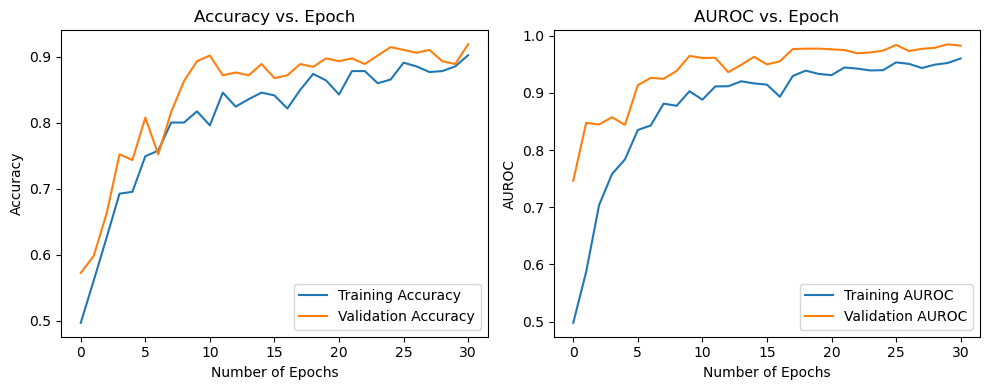

In [174]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting accuracy vs epochs 
axes[0].set_title('Accuracy vs. Epoch')
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_xlabel('Number of Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plotting AUROC vs epochs 
axes[1].set_title('AUROC vs. Epoch')
axes[1].plot(history.history['auc'], label='Training AUROC')
axes[1].plot(history.history['val_auc'], label='Validation AUROC')
axes[1].set_xlabel('Number of Epochs')
axes[1].set_ylabel('AUROC')
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

### Evaluation plots of the alternative CNN model

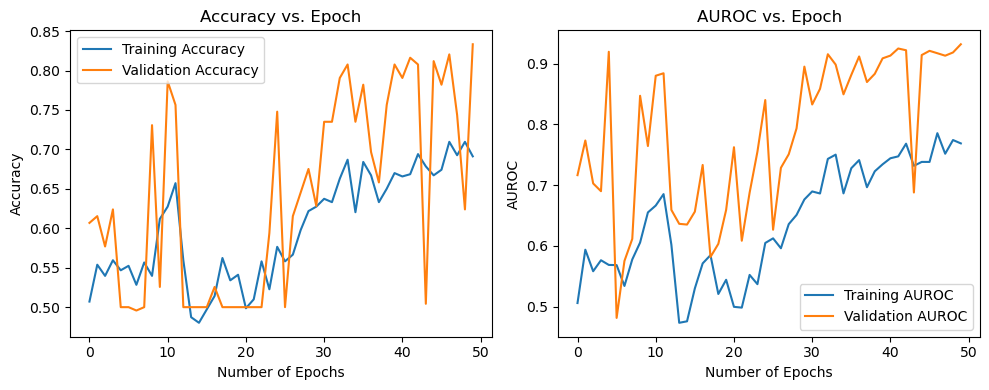

In [175]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting accuracy vs epochs 
axes[0].set_title('Accuracy vs. Epoch')
axes[0].plot(history2.history['accuracy'], label='Training Accuracy')
axes[0].plot(history2.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_xlabel('Number of Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plotting AUROC vs epochs 
axes[1].set_title('AUROC vs. Epoch')
axes[1].plot(history2.history['auc'], label='Training AUROC')
axes[1].plot(history2.history['val_auc'], label='Validation AUROC')
axes[1].set_xlabel('Number of Epochs')
axes[1].set_ylabel('AUROC')
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

### Fine-tuned model selection
The metrics show that the first CNN model performs better than the alternative CNN model.<br>
**Therefore, the first CNN model is selected to be the fine-tuned model.**

### Confusion matrix

In [144]:
# Predicting test values
pred_prob_y = cnn_model.predict(test_set)
pred_y = pred_prob_y[:,0] > 0.5
true_y = test_set.classes

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


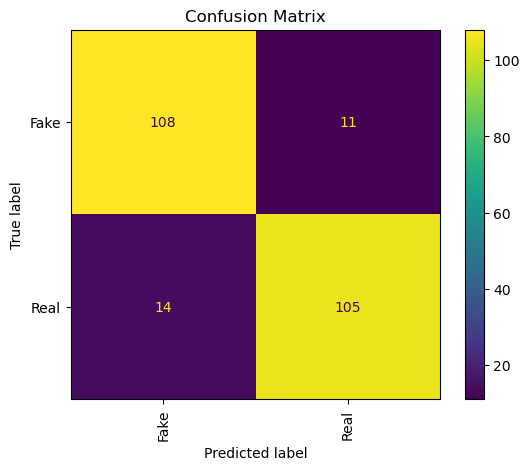

In [145]:
# Confusion matrix calculation
cm = confusion_matrix(true_y, pred_y)

# Confusion matrix plot
cm_plot = ConfusionMatrixDisplay(cm, display_labels=['Fake', 'Real']) # 0 = fake, 1 = real
cm_plot.plot()
plt.grid(False)
plt.xticks(rotation=90)
plt.title('Confusion Matrix')
plt.show()

In [146]:
# Calculating overall false pos, false neg, true pos, true neg
TN = cm[0,0]
TP = cm[1,1]

FP = cm[0,1]
FN = cm[1,0]

TP_rate = TP/(TP+FN) # prob. that an actual positive will test positive
TN_rate = TN/(TN+FP) # prob. that an actual negative will test negative
FP_rate = FP/(FP+TN) # prob. that an actual negative will test positive
FN_rate = FN/(FN+TP) # prob. that an actual positive will test negative

# Printing values
print(f'True positive rate: {TP_rate}')
print(f'True negative rate: {TN_rate}')
print(f'False positive rate: {FP_rate}')
print(f'False negative rate: {FN_rate}')

True positive rate: 0.8823529411764706
True negative rate: 0.907563025210084
False positive rate: 0.09243697478991597
False negative rate: 0.11764705882352941


### Precision and Recall

In [147]:
# calculating overall precision and recall

final_precision = TP/(TP+FP) # prob. that an predicted positive will actually be positive
final_recall = TP/(TP+FN) # prob. that an actual positive will be predicted as positive

# Printing values
print(f'Final precision: {final_precision}')
print(f'Final recall: {final_recall}')

Final precision: 0.9051724137931034
Final recall: 0.8823529411764706


In [148]:
f1 = f1_score(true_y, pred_y, average='binary')
# same as 2*(final_precision*final_recall)/(final_precision+final_recall)
print(f'F1 Score: {f1}')

F1 Score: 0.8936170212765958


### Plot ROC curve and precision-recall curve

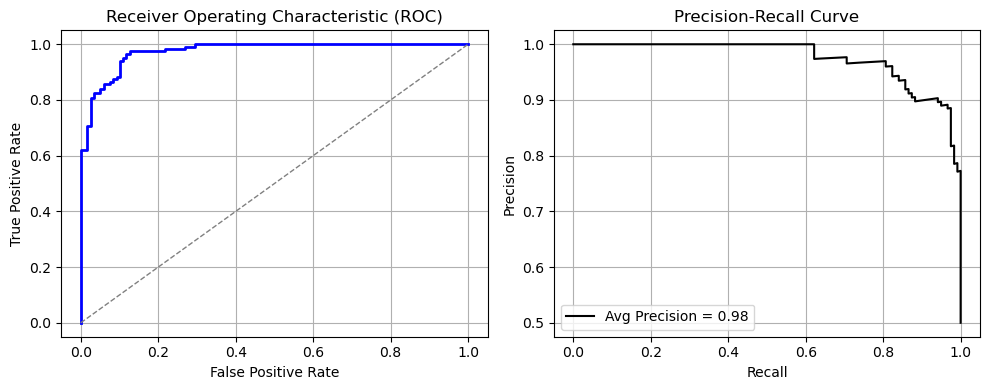

In [149]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_y, pred_prob_y)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
axes[0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Receiver Operating Characteristic (ROC)')
axes[0].grid(True)

# Plot precision-recall curve
precision, recall, thresholds = precision_recall_curve(true_y, pred_prob_y)
avg_precision = average_precision_score(true_y, pred_prob_y)

axes[1].plot(recall, precision, c='black', label=f'Avg Precision = {avg_precision:.2f}')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()